In [38]:
# imports
import pandas as pd
import numpy as np
import nltk
import time
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

## Text Preprocessing

In [12]:
# import the excel file
df = pd.read_csv('../Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


In [13]:
# keep only the reviews.rating and reviews.text columns
df = df[['reviews.rating', 'reviews.text']]
df.head()

,reviews.rating,reviews.text
0,3,I order 3 of them and one of the item is bad q...
1,4,Bulk is always the less expensive way to go fo...
2,5,Well they are not Duracell but for the price i...
3,5,Seem to work as well as name brand batteries a...
4,5,These batteries are very long lasting the pric...


In [14]:
# apply sentiment labels for the reviews.rating
df['sentiment'] = df['reviews.rating'].apply(lambda x: 'negative' if x <= 2 else ('neutral' if x == 3 else 'positive'))
df.head()

,reviews.rating,reviews.text,sentiment
0,3,I order 3 of them and one of the item is bad q...,neutral
1,4,Bulk is always the less expensive way to go fo...,positive
2,5,Well they are not Duracell but for the price i...,positive
3,5,Seem to work as well as name brand batteries a...,positive
4,5,These batteries are very long lasting the pric...,positive


In [15]:
# preprocess the reviews.text column

# get stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

nltk.download('punkt')
nltk.download('wordnet')

def preprocess_text(text):
    # remove numbers
    text = re.sub(r'\d+', '', text)

    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # remove capital letters
    text = text.lower()

    # tokenize the text
    tokens = word_tokenize(text)

    # remove stopwords and lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords]

    return ' '.join(tokens)

df['reviews.text'] = df['reviews.text'].apply(preprocess_text)
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sguir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sguir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sguir\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,reviews.rating,reviews.text,sentiment
0,3,order one item bad quality missing backup spri...,neutral
1,4,bulk always le expensive way go product like,positive
2,5,well duracell price happy,positive
3,5,seem work well name brand battery much better ...,positive
4,5,battery long lasting price great,positive


## Initial Data Visualizations

By creating a histogram of the ratings, we see that ratings tend to skew heavily towards 5 stars, suggesting to us that either people tend to leave only positive reviews or that they're failing to mark bad products low enough. This skew should be awknoledged in our model design.

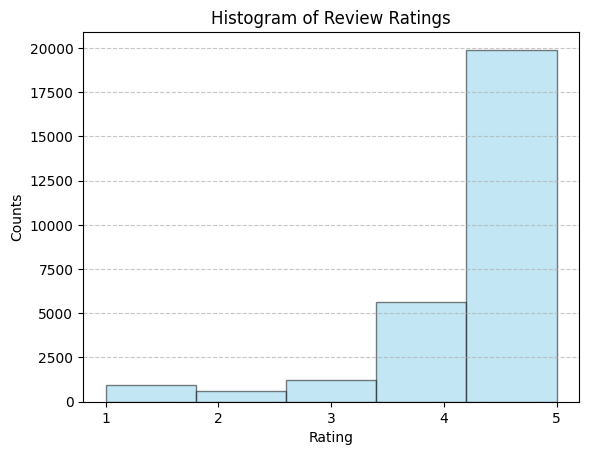

In [16]:
plt.hist(df['reviews.rating'], bins=5, color='skyblue', edgecolor='black', alpha=0.5)
plt.title('Histogram of Review Ratings')
plt.xlabel('Rating')
plt.ylabel('Counts')
plt.xticks(range(1, 6))  # Adjust x-axis ticks to match rating scale
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

From the wordclouds below we see that a majorityof the words revolve around the product with a few sentimental words. Additionally, reviews at all stars have some positive words such as "good", meaning that the model may not be able to rely on few words to give its prediction.

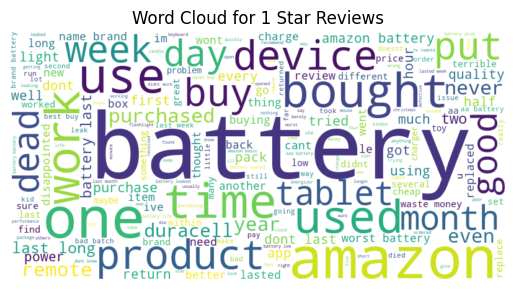

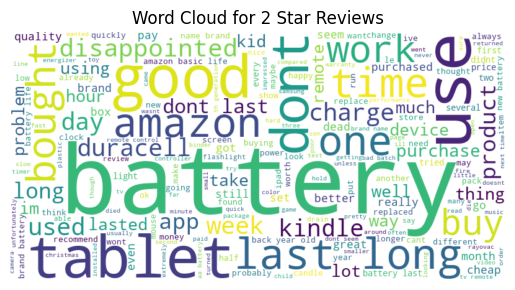

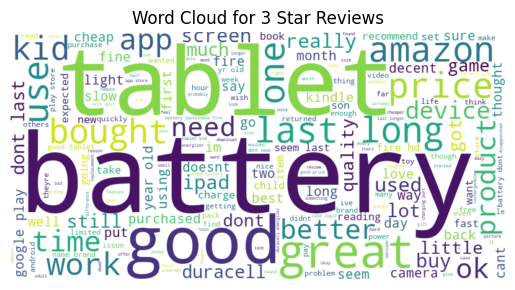

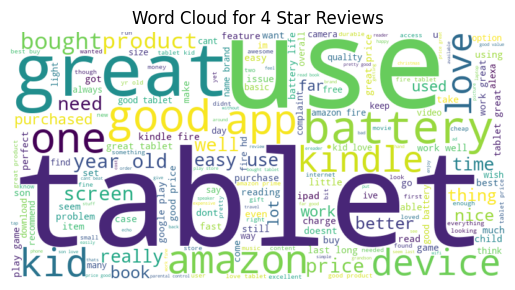

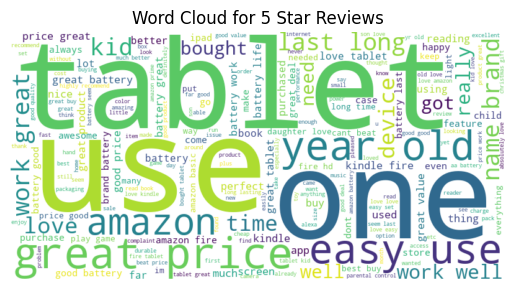

In [17]:
for rating in range(1,6):
    reviews_subset = df[df['reviews.rating'] == rating]['reviews.text']
    text = ' '.join(reviews_subset)
    
    # Create word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {rating} Star Reviews')
    plt.axis('off')
    plt.show()

## Create Word Embeddings

We will use the Word2Vec model to create word embeddings. This model will create a vector representation of each word in the corpus. This will allow us to use the word embeddings to capture the semantic meaning of the words in the reviews.

In [18]:
# load the word2vec model
word2vec_model = KeyedVectors.load_word2vec_format('../GoogleNews-vectors-negative300.bin.gz', binary=True)

In [24]:
# get the word embeddings for the reviews in the dataset
def get_sentence_embedding(sentence):
    words = sentence.split()
    embeddings = [word2vec_model[word] for word in words if word in word2vec_model]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)
    
df['embeddings'] = df['reviews.text'].apply(get_sentence_embedding)
df.head()

,reviews.rating,reviews.text,sentiment,embeddings
0,3,order one item bad quality missing backup spri...,neutral,"[-0.002293178, 0.09266444, 0.0023612976, 0.035..."
1,4,bulk always le expensive way go product like,positive,"[0.037750244, 0.11250305, 0.005601883, 0.13848..."
2,5,well duracell price happy,positive,"[0.019521078, 0.05183919, -0.11079153, 0.09977..."
3,5,seem work well name brand battery much better ...,positive,"[0.050726995, 0.0601671, -0.032755535, 0.08175..."
4,5,battery long lasting price great,positive,"[-0.0078125, 0.14204101, -0.021166991, 0.08242..."


## Model Comparison

We will compare the performance of the following models (their ability to predict the rating of a review):
- Logistic Regression
- Random Forest
- Neural Network

In [30]:
# split the dataset into training and testing sets
X = np.array(df['embeddings'].to_list())
y = df['reviews.rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# train a logistic regression model
model = LogisticRegression()

start_time = time.time()
model.fit(X_train, y_train)
training_time = time.time() - start_time

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(f'Training Time: {training_time:.2f} seconds')

Accuracy: 0.72
Training Time: 1.72 seconds


In [40]:
# train a random forest model
model = RandomForestClassifier()

start_time = time.time()
model.fit(X_train, y_train)
training_time = time.time() - start_time

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(f'Training Time: {training_time:.2f} seconds')

Accuracy: 0.85
Training Time: 48.69 seconds
